## Creating Biased Datasets Using Simstudy

In this notebook, we will be using Simstudy to simulate a dataset in which certain outcomes are biased, conditional on certain characteristics. We aim to demonstrate how Simstudy can be used to develop accelerators, as well as Trustworthy AI demos. By specifying the relationships between inputs and outputs ahead of time, we can see how well different algorithms do at estimating these relationships.

Let's start with the building blocks of the pysimstudy package. 

The goal of this first example is to display the core steps in generating data with pysimstudy, while also exploring the art of whats possible through interesting questions of statistical nature. We will work to create a dataset of people represented by an arbitrary id, along with their income. The target variable will be approval, which will be biased to have more approvals if your income is higher. Our goal is to show that we can hard-code bias into an approval rating process based on a random variable.

The first step is to define a _definitions_ data table in which we describe the variables we want to generate. We pass arguments to define the generated variable's name (varname), as well as its statistical parameters. The _formula_ argument refers to the variable's mean, or expected value, and _variance_ is self evident. The _formula_ argument allows you to pass an equation to generate your data.

In [1]:
from pysimstudy import *

In [14]:
ddf = defData(varname = "region", formula="0.333, 0.333, 0.333",
             variance="red, blue, green", dist="categorical")

We then define our target variable, __approval__. We add a new row to the data definitions table created in the previous lines of code by passing _ddf_ as the first argument. The _formula_ is defined as follows: the probability of an individual being approved is 50%, so everyone in the dataset has an equal probability of being granted a loan.

In [15]:
ddf = defData(ddf, varname="approval", formula='.5', dist='binary')
ddf

,varname,formula,variance,dist,link
0,region,"0.333,0.333,0.333","red, blue, green",categorical,identity
1,approval,.5,0,binary,identity


Now that we created the conditions for our dataset, we can generate observations based on the definitions.
We do so by calling the _genData_ function, specifying the number of observations we'd like to create (10000), as well as our data definition table _ddf_.

In [16]:
gdf = genData(10000, ddf)
gdf.head()

,id,region,approval
0,0,green,1
1,1,red,1
2,2,blue,1
3,3,green,0
4,4,blue,0


In the previous example, the _approval_ variable was not conditioned on any variable. We can now think of a scenario that is much closer to what occurs in real life: a person's loan approval acceptance being tied to their income. To that extent, let's add a new _income_ variable to our data definition table. _income_ will be normally distributed, with a mean of 5000 and a standard deviation of 1000 (_variance_ is squared since the standard deviation is the square-root of variance).

In [17]:
ddf = defData(ddf, varname = "income", formula=5000,
             variance=1000**2, dist="normal")
             
ddf

,varname,formula,variance,dist,link
0,region,"0.333,0.333,0.333","red, blue, green",categorical,identity
1,approval,.5,0,binary,identity
2,income,5000,1000000,normal,identity


We can now generate a new fake dataset with the new data definition!

In [18]:
gdf = genData(10000, ddf)
gdf.head()

,id,region,approval,income
0,0,green,1,5223.550838
1,1,blue,0,7772.471383
2,2,blue,1,4865.263832
3,3,blue,1,5789.019800
4,4,red,1,5593.598317


<AxesSubplot:>

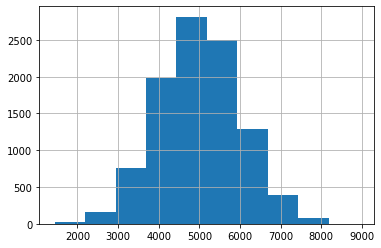

In [20]:
# We can quickly visualize the generated datapoints and validate we have the distribution we want
gdf.income.hist();

We can now leverage the _defCondition_ function to define the conditional relationship between _income_ and the loan approval process. We can divide our fake population into 3 categories and condition their approval chances accordingly:
- Those with an income higher than 6000 have a 90% chance of approval
- Those with incomes between 4000 and 6000 have a 65% chance of approval
- TThose with incomes below 4000 have a 40% chance of approval.

In [21]:
# Now we can create conditions to influence our data
defC = defCondition(condition = "income >= 6000", formula = "0.9",
                    dist = "binary")

defC = defCondition(defC, condition = "(income < 6000) & (income >= 4000)", formula = "0.65",
                    dist = "binary")

defC = defCondition(defC, condition = " (income < 4000)", formula = "0.4",
                    dist = "binary")


In [23]:
print(defC.head())

                            condition formula  variance    dist      link
0                      income >= 6000     0.9         0  binary  identity
0  (income < 6000) & (income >= 4000)    0.65         0  binary  identity
0                     (income < 4000)     0.4         0  binary  identity


Now that we created the conditions for our dataset, we can generate observations based on the previously defined conditions using the _addCondition_ function.

In [24]:
gdfb = addCondition(defC, gdf, newvar="approval_conditional")

In [25]:
gdfb.head()

,id,region,approval,income,approval_conditional
0,1,blue,0,7772.471383,1
1,7,blue,1,6190.296225,1
2,8,red,0,6331.168987,1
3,9,green,1,6861.643799,1
4,10,green,1,6457.427373,1


We can do a quick sanity check to validate our conditional distributions have been drawn from appropriately

In [26]:
gdfb[gdfb['income'] >= 6000]['approval_conditional'].value_counts(normalize=True)

1    0.895
0    0.105
Name: approval_conditional, dtype: float64

In [12]:
gdfb[(gdfb['income'] < 6000) & (gdfb['income'] >=4000)]['approval_conditional'].value_counts(normalize=True)

1    0.650766
0    0.349234
Name: approval, dtype: float64

In [13]:
gdfb[gdfb['income'] < 4000]['approval_conditional'].value_counts(normalize=True)

0    0.595972
1    0.404028
Name: approval, dtype: float64

In [30]:
gdf_dummy = pd.get_dummies(gdfb)
gdf_dummy

,id,approval,income,approval_conditional,region_blue,region_green,region_red
0,1,0,7772.471383,1,1,0,0
1,7,1,6190.296225,1,1,0,0
2,8,0,6331.168987,1,0,0,1
3,9,1,6861.643799,1,0,1,0
4,10,1,6457.427373,1,0,1,0
...,...,...,...,...,...,...,...
9995,9970,0,3119.570955,1,0,0,1
9996,9978,1,2859.265779,1,0,1,0
9997,9986,1,3249.912987,0,0,0,1
9998,9991,1,3549.438333,1,1,0,0


In [31]:
defC = defCondition(condition = "income >= 6000", formula = "0.9*(0.9*region_blue)",
                    dist = "binary")

defC = defCondition(defC, condition = "(income < 6000) & (income >= 4000)", formula = "0.65*(0.9*region_blue)",
                    dist = "binary")

defC = defCondition(defC, condition = " (income < 4000)", formula = "0.4*(0.9*region_blue)",
                    dist = "binary")

In [34]:
gdfb = addCondition(defC, gdf_dummy, newvar="approval_conditional_region")

In [52]:
gdfb.merge(gdf.region, on = 'id')

KeyError: 'id'

In [49]:
gdf

,id,region,approval,income
0,0,green,1,5223.550838
1,1,blue,0,7772.471383
2,2,blue,1,4865.263832
3,3,blue,1,5789.019800
4,4,red,1,5593.598317
...,...,...,...,...
9995,9995,red,0,4880.392861
9996,9996,blue,0,4681.658281
9997,9997,blue,1,5423.782549
9998,9998,red,0,4623.939693
